# rerunning Navid's GNN notebook with ERCOT
## Neema Zadeh  9/7/2021

# 1. Reading in the grid and price data

In [1]:
%matplotlib inline
import networkx as nx
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Testing the nx library 

import matplotlib.pyplot as plt
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

In [18]:
#read the graph connection
#zones are numbered as:
#hb_north	0
#hb_west	1
#hb_south	2
#hb_houston	3

#note 1: it shows each degree distbuition. for example, it says there are two nodes with degree 1, 2 & 3
G = nx.read_adjlist("ercot_zones.csv", delimiter=",") 

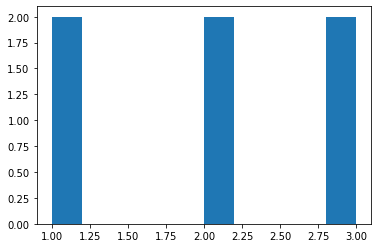

In [19]:
#teh resutls should be the same as the next block
plot_degree_dist(G) 

In [20]:
degrees = G.degree() 

# Graph degree distribution

In [21]:

degree_list=[]
for i in degrees:
    degree_list.append(i[1])
    

degree_df=pd.DataFrame(degree_list)
degree_df

degree_df[0].value_counts()

3    2
2    2
1    2
Name: 0, dtype: int64

In [22]:
#number of nodes
len(list(G.nodes)) 

6

In [23]:
#number of edges
len(G.edges()) 

6

In [24]:
G.nodes

NodeView(('from', 'to', '1', '0', '2', '3'))

In [25]:
G.edges

EdgeView([('from', 'to'), ('1', '0'), ('1', '2'), ('0', '2'), ('0', '3'), ('2', '3')])

In [26]:
nodes_list = list(G.nodes)

# nodes are strings here, changing to integers and ordering
int_nodes=[int(i) for i in nodes_list[2:]]

In [27]:
int_nodes

[1, 0, 2, 3]

# 2. Further manipulation of PyTorch Tensors


In [36]:
import torch
import torch.nn as nn
from torch.nn import Linear

#import torch_geometric.nn
from torch_geometric.nn import GCNConv

from torch_geometric.data import Data

from sklearn.decomposition import PCA

In [37]:
def graph_to_edge_list(G):

    edge_list = []
    edge_list = list(G.edges())
    return edge_list


def edge_list_to_tensor(edge_list):

    edge_index = torch.tensor([])
    edge_index = torch.tensor(np.array(edge_list), dtype=torch.long)
    edge_index = edge_index.T 
    return edge_index

In [38]:
edge_list = graph_to_edge_list(G)[1:]
edge_list = [(int(i),int(j)) for i,j in edge_list]

edge_index = edge_list_to_tensor(edge_list)

print("The edge_index tensor has shape {}".format(edge_index.shape))
print("The edge_index tensor has sum value {}".format(torch.sum(edge_index)))

The edge_index tensor has shape torch.Size([2, 5])
The edge_index tensor has sum value 14


In [39]:
edge_list

[(1, 0), (1, 2), (0, 2), (0, 3), (2, 3)]

In [40]:
nodes_int={} #empty dictionary 
nodes_int_sorted={}

for i,j in edge_list:
    if i not in nodes_int:
        nodes_int[i]=int(i)
    if j not in nodes_int:
        nodes_int[j]=int(j)

In [41]:
len(nodes_int) 

4

In [42]:
sorted_edge_list = [(nodes_int[i],nodes_int[j]) for i,j in edge_list]

print(sorted_edge_list[0])

'''
for i in sorted (nodes_int): 
    print ((i, nodes_int[i]), end =" ")
'''

(1, 0)


'\nfor i in sorted (nodes_int): \n    print ((i, nodes_int[i]), end =" ")\n'

In [43]:
sorted_edge_index = edge_list_to_tensor(sorted_edge_list) 

In [44]:
sorted_edge_index 

tensor([[1, 1, 0, 0, 2],
        [0, 2, 2, 3, 3]])

In [45]:
edge_index

tensor([[1, 1, 0, 0, 2],
        [0, 2, 2, 3, 3]])

## I am not sure why price data are assgined to edges instead of nodes

In [46]:
# creating the embedding layer skeleton, random assignment for now (before training):

torch.manual_seed(1)

def create_node_emb(num_nodes=len(nodes_int), embedding_dim=16):

    emb = None

    emb = nn.Embedding(num_nodes, embedding_dim)
    emb.weight.data = torch.rand(num_nodes, embedding_dim)

    return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Printing the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))


Embedding: Embedding(4, 16)
tensor([[0.2197, 0.4177, 0.4903, 0.5730, 0.1205, 0.1452, 0.7720, 0.3828, 0.7442,
         0.5285, 0.6642, 0.6099, 0.6818, 0.7479, 0.0369, 0.7517],
        [0.9741, 0.1682, 0.5625, 0.8731, 0.8622, 0.8106, 0.1381, 0.1399, 0.1976,
         0.5628, 0.9983, 0.1842, 0.7664, 0.2233, 0.0299, 0.3937]],
       grad_fn=<EmbeddingBackward>)


In [47]:
emb

Embedding(4, 16)

In [48]:
emb(torch.tensor(2))
 

tensor([0.6705, 0.5896, 0.2873, 0.3486, 0.9579, 0.4075, 0.7819, 0.7165, 0.1768,
        0.0748, 0.9799, 0.5261, 0.8427, 0.6036, 0.6608, 0.8735],
       grad_fn=<EmbeddingBackward>)

In [49]:
print(nx.average_clustering(G)) 

0.5555555555555555


In [50]:
#no need to use the following two blocks:
sorted_nodes={}

k=0
for i,j in edge_list:
    if i not in sorted_nodes:
        sorted_nodes[i]=k
        k+=1
    if j not in sorted_nodes:
        sorted_nodes[j]=k
        k+=1

In [51]:
edge_list_final=[]
for i,j in edge_list:
    edge_list_final.append(list([sorted_nodes[i],sorted_nodes[j]]))

In [53]:
edge_list_final

[[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]]